In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import mrcnn libraries
#sys.path.append("/home/redne/repos/Mask_RCNN/") 
sys.path.append("../") 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

sys.path.append("../../../DataManager/coco_tools/")
from coco_vis_utils import *

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [6]:
DATASET_ROOT = '/mnt/omreast_users/phhale/zerowaste/02-datasets/ds2/'
dataset_val = CocoLikeDataset()
dataset_val.load_data(os.path.join(DATASET_ROOT, 'coco_ds_3class/val_coco_instances.json'),
                        os.path.join(DATASET_ROOT, 'images'))
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 9
Class Count: 4
  0. BG                                                
  1. clearCup                                          
  2. coffeeCup                                         
  3. ms_utensils                                       


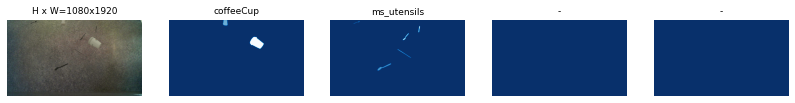

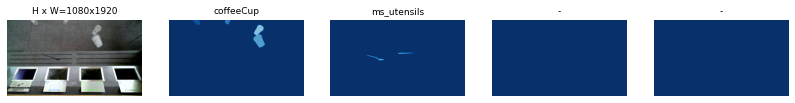

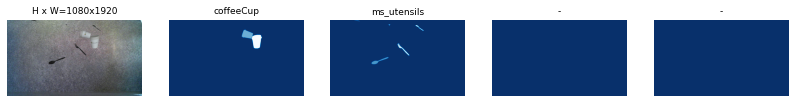

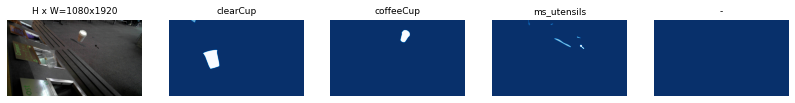

In [7]:
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

__set model params__

In [8]:
from model_config.zerowaste_config import ZeroWaste_maskrcnn_config
config = ZeroWaste_maskrcnn_config()

class InferenceConfig(ZeroWaste_maskrcnn_config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.55
    
inference_config = InferenceConfig()

__load model weights__

In [9]:
# Recreate the model in inference mode
MODEL_DIR = '/mnt/omreast_users/phhale/zerowaste/03-experiments/ds2/maskrcnn/logs/'

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
                          #model_dir=MODEL_DIR)
    
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = model.find_last()
#model_path = '/home/redne/ZeroWaste3D/research/CleanOcean/models/test_exp/logs/cig_butts20201018T1443/mask_rcnn_cig_butts_0008.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /mnt/omreast_users/phhale/zerowaste/03-experiments/ds2/maskrcnn/logs/waterwaste_ds020201019T2200/mask_rcnn_waterwaste_ds0_0001.h5
Re-starting from epoch 1


In [10]:
import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=15):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

ap range, 0.32925170901275813
ap range, 0.4611111218730608
ap range, 0.29682540463076695
ap range, 0.3375
mAP50:  0.7004676957925161
mAP range:  0.3561720588791465


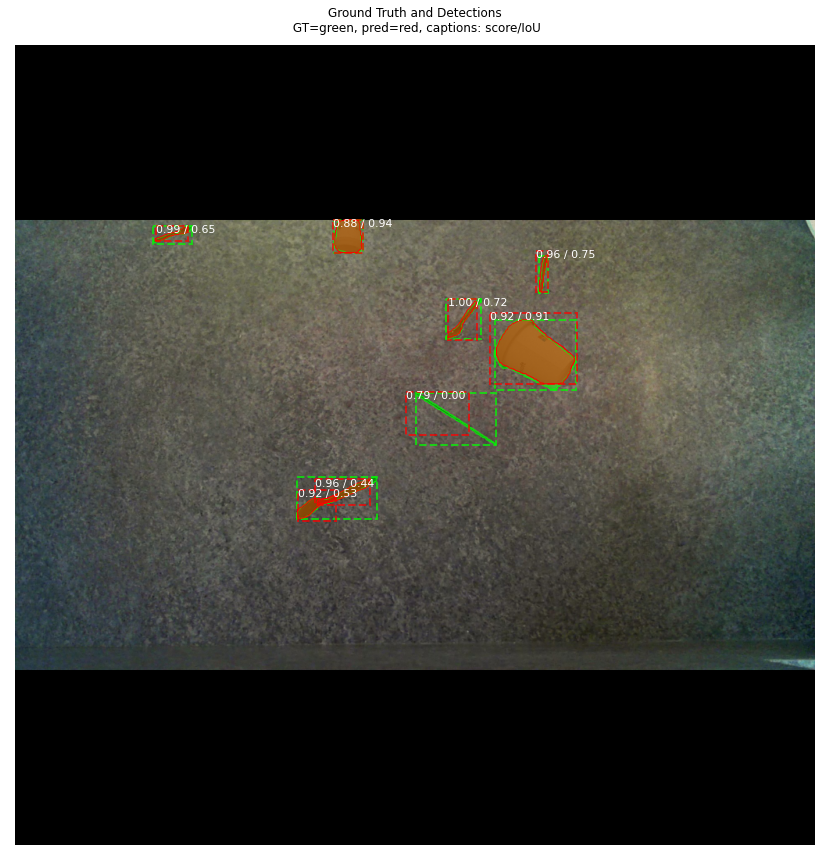

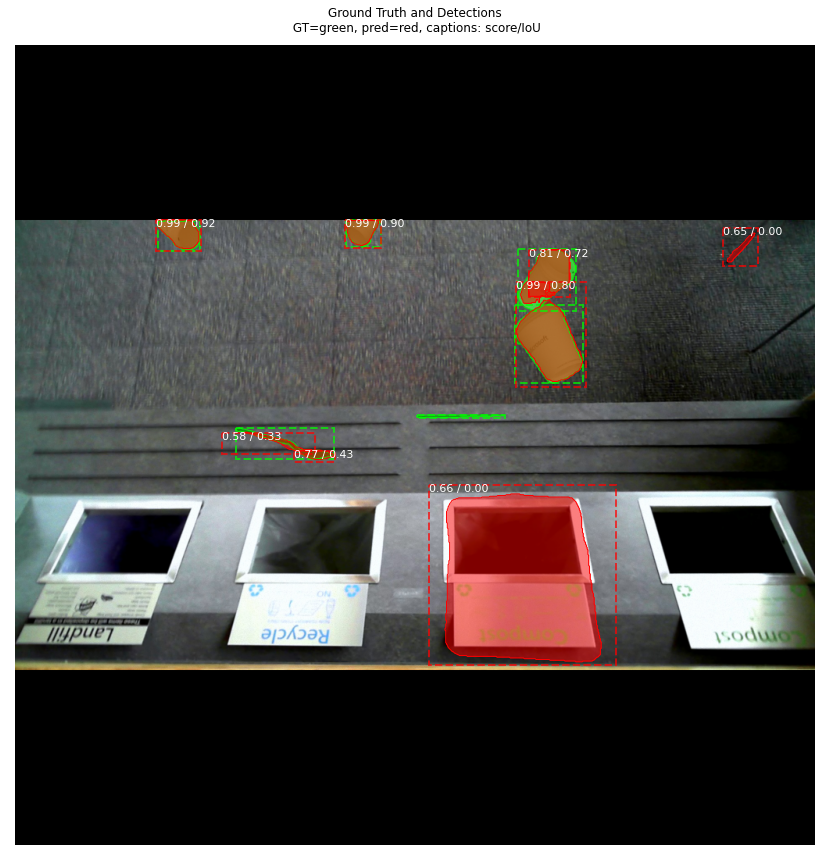

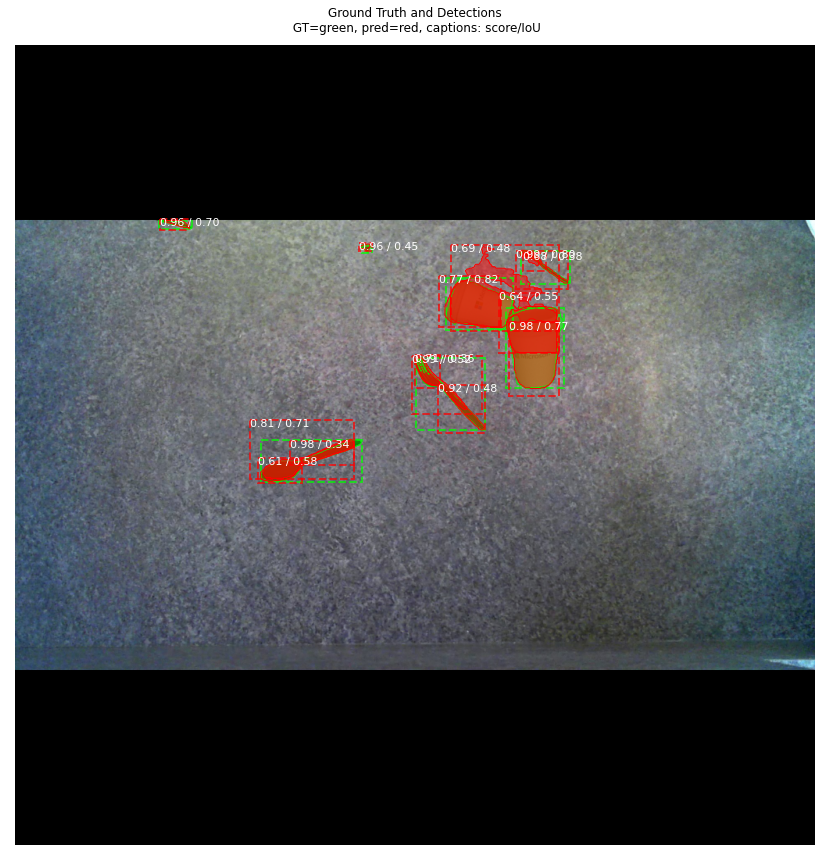

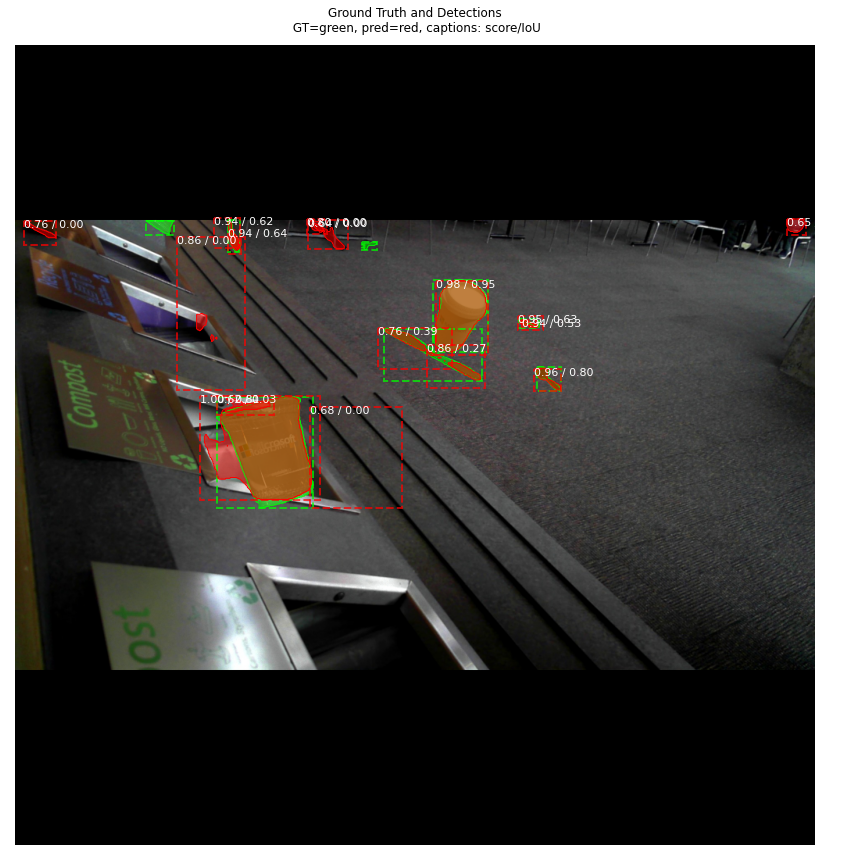

In [11]:
APs = []
APs_range = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
    # For debugging
    # print('image_id',image_id)
    # info = dataset_val.image_info[image_id]
    # print('image info ', info)
    # print('rois', r['rois'].shape)
    # print('gt_bbox', gt_bbox.shape)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])

    new_ap = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                                    r["rois"], r["class_ids"], r["scores"], 
                                    r['masks'], verbose=0)
    print("ap range,", new_ap)

    APs.append(AP)
    APs_range.append(new_ap)
    ax = get_ax()
    visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'],r['scores'],r['masks'],
                              dataset_val.class_names,ax=ax)


print("mAP50: ", np.mean(APs))
print("mAP range: ", np.mean(APs_range))